Training Epoch 1/10: 100%|██████████| 362/362 [02:29<00:00,  2.43it/s]


Epoch 1 | Train Loss: 2.0488 | Val Acc: 0.2078 | Val F1: 0.1291
Best model saved.


Training Epoch 2/10: 100%|██████████| 362/362 [02:29<00:00,  2.43it/s]


Epoch 2 | Train Loss: 1.9587 | Val Acc: 0.2204 | Val F1: 0.1823
Best model saved.


Training Epoch 3/10: 100%|██████████| 362/362 [02:29<00:00,  2.43it/s]


Epoch 3 | Train Loss: 1.8788 | Val Acc: 0.2253 | Val F1: 0.1957
Best model saved.


Training Epoch 4/10: 100%|██████████| 362/362 [02:29<00:00,  2.43it/s]


Epoch 4 | Train Loss: 1.7851 | Val Acc: 0.2106 | Val F1: 0.1903


Training Epoch 5/10: 100%|██████████| 362/362 [02:28<00:00,  2.43it/s]


Epoch 5 | Train Loss: 1.7213 | Val Acc: 0.2197 | Val F1: 0.1966


Training Epoch 6/10: 100%|██████████| 362/362 [02:28<00:00,  2.43it/s]


Epoch 6 | Train Loss: 1.6917 | Val Acc: 0.2169 | Val F1: 0.1926


Training Epoch 7/10: 100%|██████████| 362/362 [02:29<00:00,  2.43it/s]


Epoch 7 | Train Loss: 1.6254 | Val Acc: 0.2148 | Val F1: 0.1819


Training Epoch 8/10: 100%|██████████| 362/362 [02:29<00:00,  2.43it/s]


Epoch 8 | Train Loss: 1.5585 | Val Acc: 0.2120 | Val F1: 0.1957


Training Epoch 9/10: 100%|██████████| 362/362 [02:29<00:00,  2.43it/s]


Epoch 9 | Train Loss: 1.5134 | Val Acc: 0.2197 | Val F1: 0.2105


Training Epoch 10/10: 100%|██████████| 362/362 [02:29<00:00,  2.43it/s]


Epoch 10 | Train Loss: 1.4978 | Val Acc: 0.2169 | Val F1: 0.2072


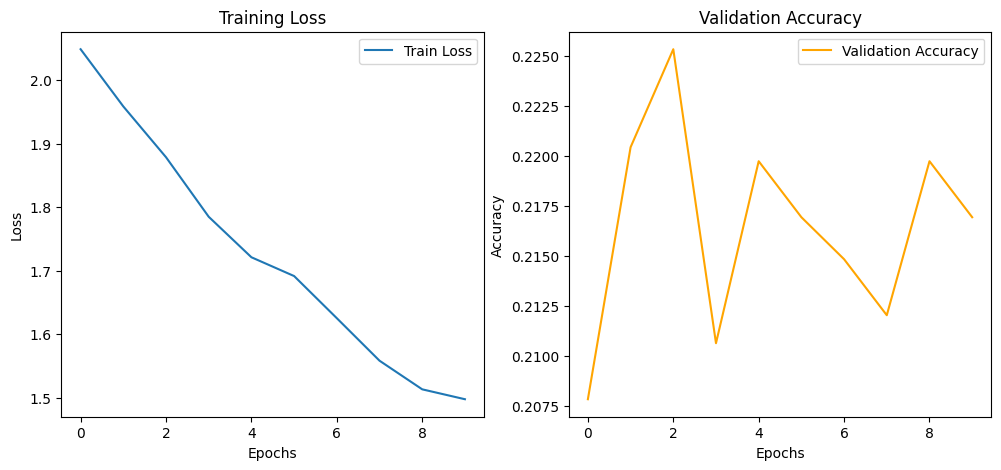

Training complete.


/tmp/ipykernel_31/3035776863.py:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_lstm_model.pt"))


Test Accuracy: 0.2431 | Test F1: 0.2161


In [4]:
import time, random, numpy as np, pandas as pd, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import BertTokenizer

# Hyperparameters and Configuration
class Config:
    batch_size = 32
    hidden_size = 256
    embedding_dim = 768  
    num_epochs = 10
    lr = 1e-2
    hidden_dropout_prob = 0.3
    seed = 11711
    num_labels = 8  # Number of classes

# Fix random seed for reproducibility
def seed_everything(seed=11711):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(Config.seed)

# Load data
def load_data(filename):
    df = pd.read_csv(filename)
    data = [(row['Summary'], row['Genres']) for _, row in df.iterrows()]
    return data

# TextDataset using the BERT tokenizer
class TextDataset(Dataset):
    def __init__(self, data, tokenizer, label_map, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.label_map = label_map
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, label = self.data[idx]
        # Tokenize and convert to IDs using the BERT tokenizer
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        token_ids = encoding['input_ids'].squeeze()  # Squeeze to remove the batch dimension
        attention_mask = encoding['attention_mask'].squeeze()
        label_id = self.label_map[label]
        return token_ids, attention_mask, label_id

    def collate_fn(self, batch):
        token_ids = torch.stack([item[0] for item in batch])
        attention_masks = torch.stack([item[1] for item in batch])
        labels = torch.tensor([item[2] for item in batch], dtype=torch.long)
        return token_ids, attention_masks, labels

label_map = {
    "Children's literature": 0,
    "Crime Fiction": 1,
    "Fantasy": 2,
    "Mystery": 3,
    "Non-fiction": 4,
    "Science Fiction": 5,
    "Suspense": 6,
    "Young adult literature": 7
}

# Define the LSTM model with randomly initialized embeddings
class LSTMSentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, config):
        super(LSTMSentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, config.hidden_size, batch_first=True)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.fc = nn.Linear(config.hidden_size, config.num_labels)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x, attention_mask=None):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        hidden = self.dropout(hidden[-1])
        return self.softmax(self.fc(hidden))

# Training function
def train_model(model, train_loader, val_loader, config, device):
    optimizer = Adam(model.parameters(), lr=config.lr)
    best_accuracy = 0

    # Track metrics for plotting
    train_losses, val_accuracies = [], []

    for epoch in range(config.num_epochs):
        model.train()
        total_loss = 0
        for token_ids, attention_masks, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{config.num_epochs}"):
            token_ids, attention_masks, labels = token_ids.to(device), attention_masks.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(token_ids, attention_mask=attention_masks)
            loss = F.nll_loss(output, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        val_accuracy, val_f1 = evaluate_model(model, val_loader, device)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f} | Val Acc: {val_accuracy:.4f} | Val F1: {val_f1:.4f}")
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), "best_lstm_model.pt")
            print("Best model saved.")

    # Plotting the training process
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()

    plt.show()

# Evaluation function
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for token_ids, attention_masks, labels in dataloader:
            token_ids, attention_masks, labels = token_ids.to(device), attention_masks.to(device), labels.to(device)
            output = model(token_ids, attention_mask=attention_masks)
            preds = torch.argmax(output, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    return accuracy, f1

# Load and process data
train_data = load_data('/kaggle/input/book-summaries/book_summaries_train.csv')
val_data = load_data('/kaggle/input/book-summaries/book_summaries_valid.csv')
test_data = load_data('/kaggle/input/book-summaries/book_summaries_test.csv')

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = TextDataset(train_data, tokenizer, label_map)
val_dataset = TextDataset(val_data, tokenizer, label_map)
test_dataset = TextDataset(test_data, tokenizer, label_map)

train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)
val_loader = DataLoader(val_dataset, batch_size=Config.batch_size, shuffle=False, collate_fn=val_dataset.collate_fn)
test_loader = DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False, collate_fn=test_dataset.collate_fn)

# Initialize model, set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMSentClassifier(tokenizer.vocab_size, Config.embedding_dim, Config).to(device)

# Train and evaluate
train_model(model, train_loader, val_loader, Config, device)
print("Training complete.")

# Load the best model and evaluate on test set
model.load_state_dict(torch.load("best_lstm_model.pt"))
test_accuracy, test_f1 = evaluate_model(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.4f} | Test F1: {test_f1:.4f}")


In [ ]:
import time, random, numpy as np, pandas as pd, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import BertTokenizer
import os

# Hyperparameters and Configuration
class Config:
    batch_size = 32
    hidden_size = 256
    embedding_dim = 768  
    num_epochs = 50
    lr = 1e-3
    hidden_dropout_prob = 0.3
    seed = 11711
    num_labels = 8  # Number of classes
    checkpoint_path = "/kaggle/working/best_lstm_model.pt"  # Path to save and load checkpoint

# Fix random seed for reproducibility
def seed_everything(seed=11711):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(Config.seed)

# Load data
def load_data(filename):
    df = pd.read_csv(filename)
    data = [(row['Summary'], row['Genres']) for _, row in df.iterrows()]
    return data

# TextDataset using the BERT tokenizer
class TextDataset(Dataset):
    def __init__(self, data, tokenizer, label_map, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.label_map = label_map
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, label = self.data[idx]
        # Tokenize and convert to IDs using the BERT tokenizer
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        token_ids = encoding['input_ids'].squeeze()  # Squeeze to remove the batch dimension
        attention_mask = encoding['attention_mask'].squeeze()
        label_id = self.label_map[label]
        return token_ids, attention_mask, label_id

    def collate_fn(self, batch):
        token_ids = torch.stack([item[0] for item in batch])
        attention_masks = torch.stack([item[1] for item in batch])
        labels = torch.tensor([item[2] for item in batch], dtype=torch.long)
        return token_ids, attention_masks, labels

label_map = {
    "Children's literature": 0,
    "Crime Fiction": 1,
    "Fantasy": 2,
    "Mystery": 3,
    "Non-fiction": 4,
    "Science Fiction": 5,
    "Suspense": 6,
    "Young adult literature": 7
}

# Define the LSTM model with randomly initialized embeddings
class LSTMSentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, config):
        super(LSTMSentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, config.hidden_size, batch_first=True)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.fc = nn.Linear(config.hidden_size, config.num_labels)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x, attention_mask=None):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        hidden = self.dropout(hidden[-1])
        return self.softmax(self.fc(hidden))

# Evaluation function to calculate accuracy and f1 score
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for token_ids, attention_masks, labels in dataloader:
            token_ids, attention_masks, labels = token_ids.to(device), attention_masks.to(device), labels.to(device)
            output = model(token_ids, attention_mask=attention_masks)
            preds = torch.argmax(output, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    return accuracy, f1

# Training function with checkpoint loading and saving
def train_model(model, train_loader, val_loader, config, device):
    optimizer = Adam(model.parameters(), lr=config.lr)
    start_epoch = 0
    best_accuracy = 0

    # Check if checkpoint exists and load it if possible
    if os.path.exists(config.checkpoint_path):
        try:
            checkpoint = torch.load(config.checkpoint_path)
            if 'model_state_dict' in checkpoint and 'optimizer_state_dict' in checkpoint:
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                start_epoch = checkpoint['epoch'] + 1
                best_accuracy = checkpoint.get('best_accuracy', 0)
                print(f"Checkpoint loaded. Resuming training from epoch {start_epoch} with best accuracy {best_accuracy:.4f}")
            else:
                print("Checkpoint file does not contain the expected keys. Starting training from scratch.")
        except Exception as e:
            print(f"Error loading checkpoint: {e}. Starting training from scratch.")
    else:
        print("No checkpoint found. Starting training from scratch.")

    # Track metrics for plotting
    train_losses, train_accuracies, val_accuracies = [], [], []

    for epoch in range(start_epoch, config.num_epochs):
        model.train()
        total_loss = 0
        correct_preds = 0
        total_samples = 0

        for token_ids, attention_masks, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{config.num_epochs}"):
            token_ids, attention_masks, labels = token_ids.to(device), attention_masks.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(token_ids, attention_mask=attention_masks)
            loss = F.nll_loss(output, labels)
            loss.backward()
            optimizer.step()

            # Calculate training loss and accuracy
            total_loss += loss.item()
            preds = torch.argmax(output, dim=1)
            correct_preds += (preds == labels).sum().item()
            total_samples += labels.size(0)

        # Average train loss and accuracy
        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = correct_preds / total_samples
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation accuracy
        val_accuracy, val_f1 = evaluate_model(model, val_loader, device)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Val Acc: {val_accuracy:.4f}")

        # Save checkpoint if validation accuracy improves
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_accuracy': best_accuracy,
            }, config.checkpoint_path)
            print("Checkpoint saved.")

    # Plotting the training process
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()

    plt.show()


# Load and process data
train_data = load_data('/kaggle/input/book-summaries/book_summaries_train.csv')
val_data = load_data('/kaggle/input/book-summaries/book_summaries_valid.csv')
test_data = load_data('/kaggle/input/book-summaries/book_summaries_test.csv')

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = TextDataset(train_data, tokenizer, label_map)
val_dataset = TextDataset(val_data, tokenizer, label_map)
test_dataset = TextDataset(test_data, tokenizer, label_map)

train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)
val_loader = DataLoader(val_dataset, batch_size=Config.batch_size, shuffle=False, collate_fn=val_dataset.collate_fn)
test_loader = DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False, collate_fn=test_dataset.collate_fn)

# Initialize model, set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMSentClassifier(tokenizer.vocab_size, Config.embedding_dim, Config).to(device)

# Train and evaluate
train_model(model, train_loader, val_loader, Config, device)
print("Training complete.")

# Load the best model and evaluate on test set
model.load_state_dict(torch.load(Config.checkpoint_path)['model_state_dict'])
test_accuracy, test_f1 = evaluate_model


/tmp/ipykernel_31/2409394052.py:125: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(config.checkpoint_path)


Checkpoint loaded. Resuming training from epoch 29 with best accuracy 0.3975


Training Epoch 30/50:  73%|███████▎  | 263/362 [01:47<00:35,  2.79it/s]

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, recall_score

# Configuration
class Config:
    batch_size = 32
    hidden_size = 256
    embedding_dim = 768  
    num_epochs = 50
    lr = 1e-3
    hidden_dropout_prob = 0.3
    seed = 11711
    num_labels = 8  # Number of classes
    checkpoint_path = "/kaggle/working/best_lstm_model.pt"  # Path to the checkpoint

# Label map for genres
label_map = {
    "Children's literature": 0,
    "Crime Fiction": 1,
    "Fantasy": 2,
    "Mystery": 3,
    "Non-fiction": 4,
    "Science Fiction": 5,
    "Suspense": 6,
    "Young adult literature": 7
}

# Define the LSTM model with randomly initialized embeddings
class LSTMSentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, config):
        super(LSTMSentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, config.hidden_size, batch_first=True)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.fc = nn.Linear(config.hidden_size, config.num_labels)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x, attention_mask=None):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        hidden = self.dropout(hidden[-1])
        return self.softmax(self.fc(hidden))

# Dataset class for loading the data
class TextDataset(Dataset):
    def __init__(self, data, tokenizer, label_map, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.label_map = label_map
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, label = self.data[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        token_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        label_id = self.label_map[label]
        return token_ids, attention_mask, label_id

    def collate_fn(self, batch):
        token_ids = torch.stack([item[0] for item in batch])
        attention_masks = torch.stack([item[1] for item in batch])
        labels = torch.tensor([item[2] for item in batch], dtype=torch.long)
        return token_ids, attention_masks, labels

# Function to load data from CSV
def load_data(filename):
    df = pd.read_csv(filename)
    data = [(row['Summary'], row['Genres']) for _, row in df.iterrows()]
    return data

# Evaluation function to calculate accuracy, F1 score, and recall
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for token_ids, attention_masks, labels in dataloader:
            token_ids, attention_masks, labels = token_ids.to(device), attention_masks.to(device), labels.to(device)
            output = model(token_ids, attention_mask=attention_masks)
            preds = torch.argmax(output, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")
    return accuracy, f1, recall

# Load the checkpoint and evaluate on the test set
def load_checkpoint_and_evaluate(checkpoint_path, test_loader, device):
    # Initialize model and load checkpoint
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = LSTMSentClassifier(tokenizer.vocab_size, Config.embedding_dim, Config).to(device)
    
    if torch.cuda.is_available():
        checkpoint = torch.load(checkpoint_path)
    else:
        checkpoint = torch.load(checkpoint_path, map_location=device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Checkpoint loaded. Evaluating on test set...")

    # Evaluate on test set
    test_accuracy, test_f1, test_recall = evaluate_model(model, test_loader, device)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")
    print(f"Test Recall: {test_recall:.4f}")

# Load test data
test_data = load_data('/kaggle/input/book-summaries/book_summaries_test.csv')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
test_dataset = TextDataset(test_data, tokenizer, label_map)
test_loader = DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False, collate_fn=test_dataset.collate_fn)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluate the model on the test set using the checkpoint
load_checkpoint_and_evaluate(Config.checkpoint_path, test_loader, device)


/tmp/ipykernel_31/3061299579.py:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Checkpoint loaded. Evaluating on test set...
Test Accuracy: 0.4078
Test F1 Score: 0.3968
Test Recall: 0.3972
